In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy.stats import ttest_ind

In [3]:
# load data
def get_cmv_only(df, jason=True):
    """Returns a DataFrame with only CMV specific antigens
    
    Args:
        df (DataFrame): Tidied CMV study DataFrame
        jason (Boolean): Whether to include McLellan pentamer
        
    Returns:
        cmv_df (DataFrame): Tidied DataFrame with only CMV specific antigens
    
    """
    if jason==True:
        cmv_antigens = ['prefusion gB', 'postfusion gB', 'CG1', 'CG2',
               'pentamer - McLellan', 'pentamer', 'gB']
    else:
        cmv_antigens = ['CG1', 'CG2', 'pentamer', 'gB']

    regspec = [x.split("_") for x in df.columns[2:]]
    regspec_df = pd.DataFrame(regspec, columns=["Reagent", "Antigen"])

    cmv_regspec = regspec_df[regspec_df['Antigen'].isin(cmv_antigens)].copy()
    cmv_regspec["cols"] = cmv_regspec["Reagent"] + "_" + cmv_regspec["Antigen"]
    cmv_cols = list(cmv_regspec["cols"])

    df_cmv = df[list(df.columns[:2]) + cmv_cols].copy()
    
    return df_cmv

def sample_cleaner(sample):
    sample = sample.replace("-", "").lower().strip()
    return sample

def add_adcp(cmv):
    adcp_gb = pd.read_excel("../data/raw/ADCP_CMV.xlsx", sheet_name="gB")
    adcp_cg1 = pd.read_excel("../data/raw/ADCP_CMV.xlsx", sheet_name="CG1")
    adcp_cg2 = pd.read_excel("../data/raw/ADCP_CMV.xlsx", sheet_name="CG2")
    adcp_pentamer = pd.read_excel("../data/raw/ADCP_CMV.xlsx", sheet_name="Pentamer")

    dfs = [adcp_gb, adcp_cg1, adcp_cg2, adcp_pentamer]

    for df in dfs:
        df.Samples = df.Samples.apply(sample_cleaner)

    cmv.Sample = cmv.Sample.apply(sample_cleaner)
    
    new_antigens = ['gB', 'CG1', 'CG2', 'pentamer']

    for i, df in enumerate(dfs):
        cols = ["Sample", "ADCP_" + new_antigens[i]]
        df.columns = cols

    for df in dfs:
        cmv = pd.merge(cmv, df, how='outer', left_on="Sample", right_on="Sample")

    cmv_adcp = cmv.dropna(subset=["Cohort"])
    
    return cmv_adcp

def find_final_visits(value):
    if value.endswith("v") or value.endswith("v4"):
        return True
    else:
        return False
    
def find_longitudinal_samples(df):
    final_visits = list(df[df.Sample.apply(find_final_visits)].Sample)
    first_visits = [x.split("v")[0] for x in final_visits]
    longitudinal = first_visits + final_visits
    return longitudinal, first_visits, final_visits

In [4]:
df = pd.read_csv("../data/processed/190530_merged_cmv_remmel.csv")

In [5]:
df = df.loc[df.Cohort.isin(['PP', 'NL', 'NP', 'PL', 'PP_Erasmus'])]
df = get_cmv_only(df, jason=True)
df = add_adcp(df)

In [6]:
# drop final visits
longitudinal, first_visits, final_visits = find_longitudinal_samples(df)
df = df.loc[~df.Sample.isin(final_visits)].copy()

In [7]:
# create primary/latent column
# create pregnant/non-pregnant column
df['Primary'] = df.Cohort.apply(lambda x: "Primary" if x in ['PP', 'NP', 'PP_Erasmus'] else "Latent")
df['Pregnant'] = df.Cohort.apply(lambda x: "Pregnant" if x in ['PP', 'PP', 'PP_Erasmus'] else "Non-Pregnant")
df.loc[df.Cohort == 'PP_Erasmus', 'Primary'] = 'Erasmus'

In [8]:
def featuremap(cmv):
    iden = ['Sample', 'Cohort', 'Pregnant', 'Primary']
    features = list(df.loc[:,~df.columns.isin(iden)].columns)
    
    pairs = [x.split("_") for x in features]

    fmap = pd.DataFrame(pairs)

    fmap['feature'] = features

    fmap.columns = ['reagent', 'antigen', 'feature']
    fmap = fmap[['feature', 'reagent', 'antigen']]

    return fmap

In [9]:
def colormap(df):
    fmap = featuremap(df)
    
    reagent_pal = (
        sns.color_palette("Set1")[3:-1] + 
        sns.color_palette("Blues_r")[:2] + 
        sns.color_palette("Greens_r")[:2] + 
        sns.color_palette("Reds_r")[:3] +
        [sns.color_palette("Set1")[-1]]
    )
    
    rmap = {
        'C1Q': reagent_pal[0],
        'IgM.1000f': reagent_pal[1],
        'IgM.250f': reagent_pal[1],
        'FcRN': reagent_pal[2],
        'IgA': reagent_pal[3],
        'IgA1': reagent_pal[3],
        'IgA2': reagent_pal[3],
        'FcAR': reagent_pal[3],
        'aHuIgG.5000f': reagent_pal[4],
        'aHuIgG.1000f': reagent_pal[4],
        'IgG1': reagent_pal[5],
        'IgG3': reagent_pal[6],
        'IgG2': reagent_pal[7],
        'IgG4': reagent_pal[8],
        '3BNA2': reagent_pal[9],
        '3AF': reagent_pal[9],
        'aHu2AR': reagent_pal[10],
        'aHu2AH': reagent_pal[10],
        '2B': reagent_pal[11],
        'ADCP': reagent_pal[12]
    }
    # Set reagent colors
    fmap['rcolors'] = fmap.reagent.map(rmap)
    # Set antigen colors
    antigens = list(fmap.antigen.unique())
    amap = dict(zip(antigens, sns.color_palette("Set2")[0:len(antigens)]))
    fmap['acolors'] = fmap.antigen.map(amap)
    
    return fmap, rmap, amap


In [23]:
def get_fold_changes(df, fmap, column="Primary", groups=["Latent", "Primary"]):
    iden = ['Sample', 'Cohort', 'Pregnant', 'Primary', 'Erasmus_Test']
    features = list(df.loc[:,~df.columns.isin(iden)].columns)
    
    group_one = df.loc[df[column] == groups[0]]
    group_two = df.loc[df[column] == groups[1]]
    
    go_means = [np.mean(group_one[x]) for x in features]
    gt_means = [np.mean(group_two[x]) for x in features]
    
    fold_changes = pd.DataFrame({
        "Feature": features,
        groups[0]: go_means,
        groups[1]: gt_means
    })
    
    fold_changes["FC"] = np.log2(fold_changes[groups[1]] / fold_changes[groups[0]])
    
    pvals = [ttest_ind(group_one[x], group_two[x], axis=0, equal_var=False, nan_policy='omit')[1] for x in features]
    fold_changes["Pval"] = - np.log10(pvals)

    fold_changes = pd.merge(fold_changes, fmap, left_on="Feature", right_on="feature", how='left').drop("feature", axis=1)
    
    return fold_changes

In [11]:
# styling info
def get_handles_labels(ax):
    label_order = ['reagent',
     'C1Q',
     'IgM.1000f',
     'IgM.250f',
     'FcRN',
     'IgA',
     'IgA1',
     'IgA2',
     'FcAR',
     'aHuIgG.5000f',
     'aHuIgG.1000f',
     'IgG1',
     'IgG3',
     'IgG2',
     'IgG4',
     '3BNA2',
     '3AF',
     'aHu2AR',
     'aHu2AH',
     '2B',
     'ADCP',
     'antigen',
     'CG1',
     'CG2',
     'gB',
     'pentamer - McLellan',
     'pentamer',
     'postfusion gB',
     'prefusion gB']

    handles,labels = ax.get_legend_handles_labels()
    handle_dict = {}
    for h, l in zip(handles, labels):
        handle_dict[l] = h
    full_colors = list(pd.Series(label_order).map(handle_dict))

    return full_colors, label_order

In [12]:
fmap, rmap, amap = colormap(df)

In [13]:
def volcanoplot(df, column="Primary", groups=["Latent", "Primary"], filename=None):
    fmap, rmap, amap = colormap(df)
    fold_changes = get_fold_changes(df, fmap, column, groups)
    
    fig, ax = plt.subplots(figsize=(11.5, 8))
    sns.scatterplot(x="FC", y="Pval", data=fold_changes, ax=ax, hue="reagent", style="antigen", palette=rmap)
    plt.xlim(-8.2, 8.2)
    plt.ylim(-0.9471674069985706, 19.934785947502974)
    plt.axhline([np.log10(.05) * -1], linestyle="--", color="red")

    handles, labels = get_handles_labels(ax)

    plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1.025, 0.5))
    plt.title("P-Value vs Fold Change ({} to {})".format(groups[0], groups[1]))
    plt.xlabel("Log2 Fold Change")
    plt.ylabel("- Log10 p-value")
    plt.tight_layout()
    if filename:
        d = datetime.datetime.today()
        d = d.strftime('%Y%m%d')

        plt.savefig('../reports/figures/' + d + "_" + filename)
    pass

In [22]:
df.Erasmus_Test.value_counts()

Latent     55
PP         27
Erasmus    23
Name: Erasmus_Test, dtype: int64

In [17]:
df.loc[df.Cohort == 'PP_Erasmus', 'Erasmus_Test'] = 'Erasmus'
df.loc[df.Cohort == 'PP', 'Erasmus_Test'] = 'PP'
df.loc[df.Primary == 'Latent', 'Erasmus_Test'] = 'Latent'

In [40]:
df.Erasmus_Test

0      Erasmus
1      Erasmus
2      Erasmus
3      Erasmus
4      Erasmus
5      Erasmus
6      Erasmus
7      Erasmus
8      Erasmus
9      Erasmus
10     Erasmus
11     Erasmus
12     Erasmus
13     Erasmus
14     Erasmus
15     Erasmus
16     Erasmus
17     Erasmus
18     Erasmus
19     Erasmus
20     Erasmus
21     Erasmus
22     Erasmus
23          PP
24          PP
25          PP
26          PP
27          PP
28      Latent
29      Latent
        ...   
110         PP
111         PP
112         PP
113         PP
114         PP
115     Latent
117     Latent
119     Latent
121     Latent
123     Latent
125     Latent
126     Latent
127     Latent
128     Latent
129     Latent
130     Latent
131     Latent
132     Latent
133     Latent
134     Latent
135     Latent
136     Latent
137     Latent
138     Latent
139     Latent
140     Latent
141     Latent
142     Latent
143     Latent
144     Latent
Name: Erasmus_Test, Length: 130, dtype: object

In [42]:
df.loc[df.Erasmus_Test.isin(["PP", "Erasmus"])]

,Cohort,Sample,2B_CG1,2B_CG2,2B_gB,2B_pentamer,2B_pentamer - McLellan,2B_postfusion gB,2B_prefusion gB,3AF_CG1,...,aHuIgG.5000f_pentamer - McLellan,aHuIgG.5000f_postfusion gB,aHuIgG.5000f_prefusion gB,ADCP_gB,ADCP_CG1,ADCP_CG2,ADCP_pentamer,Primary,Pregnant,Erasmus_Test
0,PP_Erasmus,2485,20499.5,11044.00,150.5,187.0,284.5,19525.0,2278.0,17481.00,...,5037.000,13472.50,100932.00,NaN,NaN,NaN,NaN,Erasmus,Pregnant,Erasmus
1,PP_Erasmus,2486,63791.0,16297.50,1457.0,343.0,68148.0,81367.0,18688.0,37725.50,...,22895.500,36229.00,99126.25,NaN,NaN,NaN,NaN,Erasmus,Pregnant,Erasmus
2,PP_Erasmus,2592,33661.0,3675.00,12767.0,613.0,63333.0,69707.0,7827.0,22391.00,...,32354.500,50698.50,104641.00,NaN,NaN,NaN,NaN,Erasmus,Pregnant,Erasmus
3,PP_Erasmus,2775,40013.0,1647.50,20533.5,2834.0,113503.5,97154.0,11526.0,36659.50,...,107490.250,108137.50,115773.75,NaN,NaN,NaN,NaN,Erasmus,Pregnant,Erasmus
4,PP_Erasmus,3018,21050.0,3178.00,3593.0,302.0,14360.0,65213.0,13747.0,27825.75,...,16147.250,50400.00,109920.50,NaN,NaN,NaN,NaN,Erasmus,Pregnant,Erasmus
5,PP_Erasmus,3058,45046.0,14261.00,2415.0,525.5,96696.0,71771.0,92465.5,36980.50,...,75164.500,53392.50,127129.25,NaN,NaN,NaN,NaN,Erasmus,Pregnant,Erasmus
6,PP_Erasmus,3084,25727.0,32549.00,175.0,196.0,2402.5,33340.0,60535.0,23640.75,...,4112.750,20476.50,111623.25,NaN,NaN,NaN,NaN,Erasmus,Pregnant,Erasmus
7,PP_Erasmus,3092,20832.0,43682.00,257.0,277.0,3551.5,26106.0,12511.5,15381.75,...,15523.250,20465.00,104205.50,NaN,NaN,NaN,NaN,Erasmus,Pregnant,Erasmus
8,PP_Erasmus,3106,77480.0,32423.00,325.0,519.0,63894.5,52005.0,8871.0,42357.50,...,46599.250,54779.50,104056.50,NaN,NaN,NaN,NaN,Erasmus,Pregnant,Erasmus
9,PP_Erasmus,3107,59114.0,2412.00,5663.0,738.0,146465.5,97957.0,72114.5,34670.25,...,121947.500,87661.25,122755.75,NaN,NaN,NaN,NaN,Erasmus,Pregnant,Erasmus


In [50]:
leave_out = list(df.loc[df.Erasmus_Test == "Erasmus"].isna().sum().sort_values(ascending=False).head(14).index)

In [52]:
pp_erasmus_fc = get_fold_changes(df.loc[df.Erasmus_Test.isin(["PP", "Erasmus"]), ~df.columns.isin(leave_out)], fmap=fmap, column="Erasmus_Test", groups=['PP', 'Erasmus'])
latent_erasmus_fc = get_fold_changes(df.loc[df.Erasmus_Test.isin(["Latent", "Erasmus"]), ~df.columns.isin(leave_out)], fmap=fmap, column="Erasmus_Test", groups=['Latent', 'Erasmus'])

In [53]:
yes_one = set(pp_erasmus_fc.loc[pp_erasmus_fc.Pval <= -np.log10(.05)].Feature)

In [54]:
yes_two = set(latent_erasmus_fc.loc[latent_erasmus_fc.Pval > -np.log10(.05)].Feature)

In [55]:
feature_robust = yes_one.intersection(yes_two)

In [56]:
feature_robust

{'2B_CG1',
 '3BNA2_prefusion gB',
 'C1Q_CG1',
 'C1Q_gB',
 'FcAR_CG2',
 'FcAR_gB',
 'FcAR_pentamer - McLellan',
 'FcAR_postfusion gB',
 'IgA1_CG1',
 'IgA1_CG2',
 'IgA1_gB',
 'IgA1_pentamer - McLellan',
 'IgA1_postfusion gB',
 'IgA2_CG2',
 'IgA_CG1',
 'IgA_CG2',
 'IgA_gB',
 'IgA_postfusion gB',
 'IgG1_CG1',
 'IgM.1000f_CG1',
 'IgM.1000f_CG2',
 'IgM.1000f_gB',
 'IgM.1000f_pentamer',
 'IgM.1000f_postfusion gB',
 'IgM.1000f_prefusion gB',
 'IgM.250f_CG1',
 'IgM.250f_CG2',
 'IgM.250f_gB',
 'IgM.250f_pentamer',
 'IgM.250f_postfusion gB',
 'IgM.250f_prefusion gB',
 'aHu2AH_CG1',
 'aHu2AH_CG2',
 'aHu2AH_pentamer',
 'aHu2AR_CG1',
 'aHu2AR_gB',
 'aHu2AR_pentamer'}

/home/calre/anaconda3/lib/python3.7/site-packages/matplotlib/legend.py:798: UserWarning: Legend does not support nan instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/home/calre/anaconda3/lib/python3.7/site-packages/matplotlib/legend.py:798: UserWarning: Legend does not support nan instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


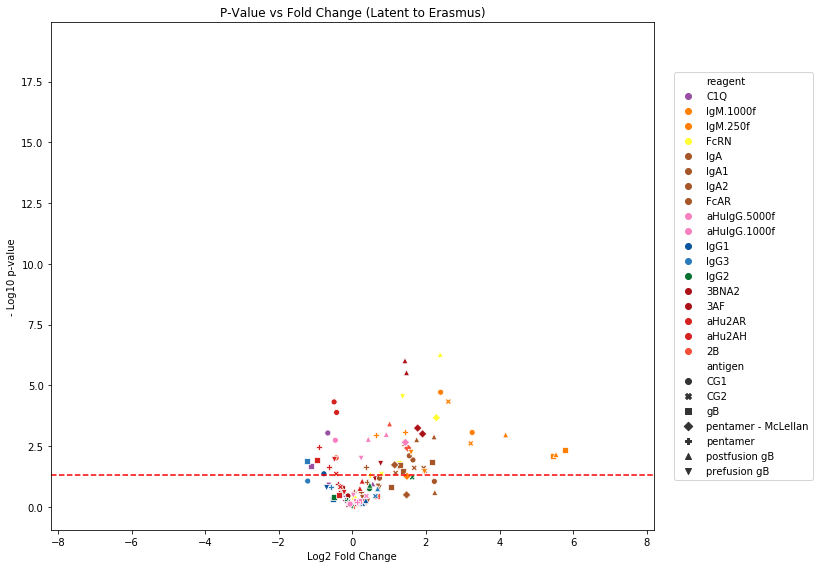

In [59]:
volcanoplot(df.loc[df.Erasmus_Test.isin(["Latent", "Erasmus"]), ~df.columns.isin(leave_out)], column="Erasmus_Test", groups=['Latent', 'Erasmus'])

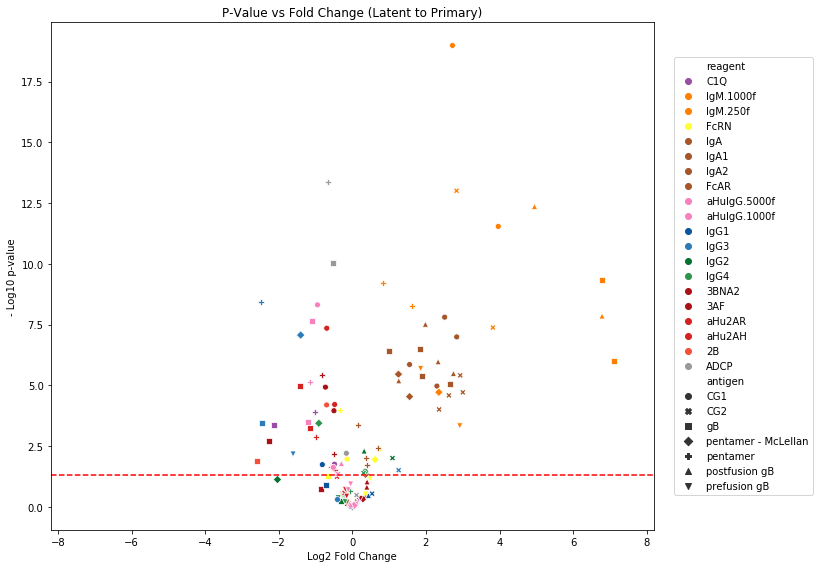

In [16]:
volcanoplot(df, filename="volplot_latent_primary.png")

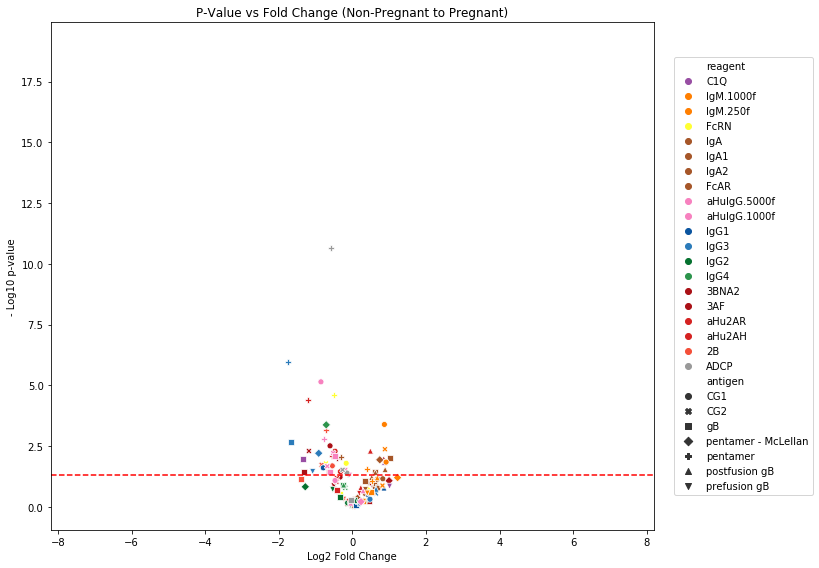

In [243]:
volcanoplot(df, column="Pregnant", groups=['Non-Pregnant', 'Pregnant'], filename="volplot_nonpregnant_pregnant.png")

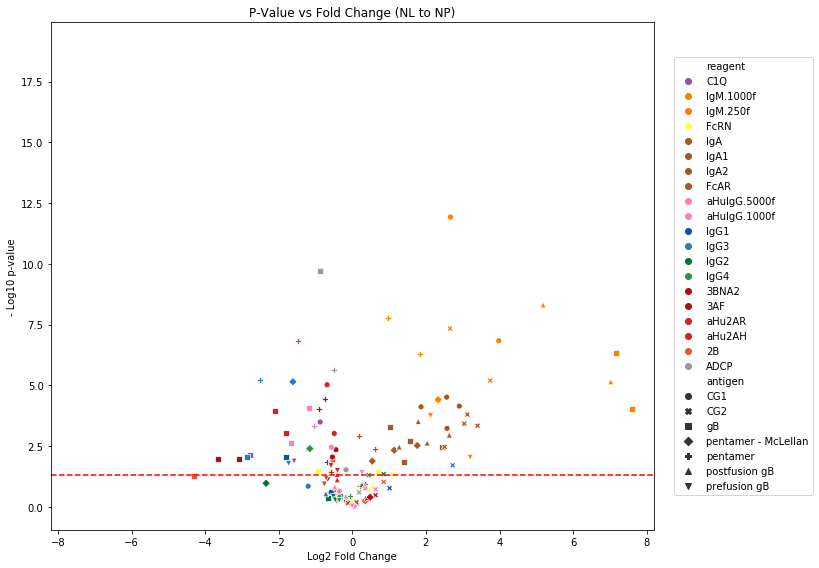

In [244]:
volcanoplot(df, column="Cohort", groups=['NL', 'NP'], filename="volplot_nl_np.png")

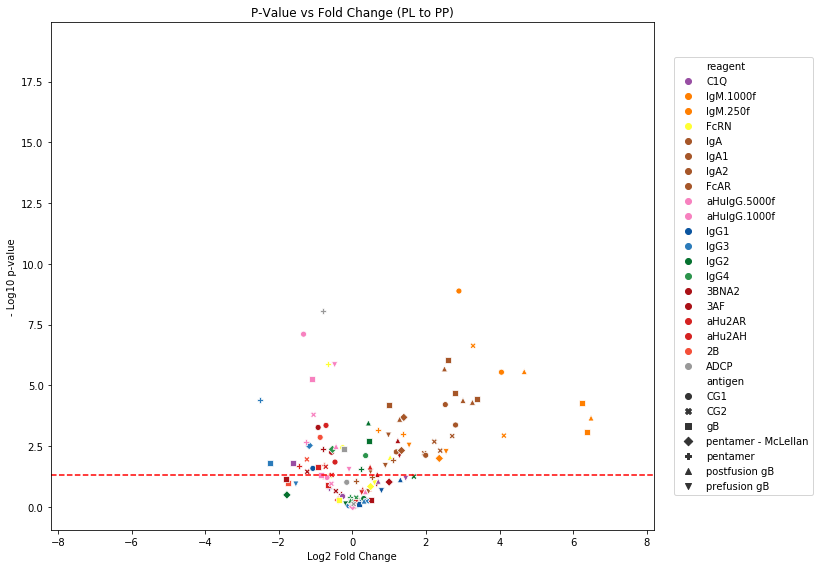

In [245]:
volcanoplot(df, column="Cohort", groups=['PL', 'PP'], filename="volplot_pl_pp.png")

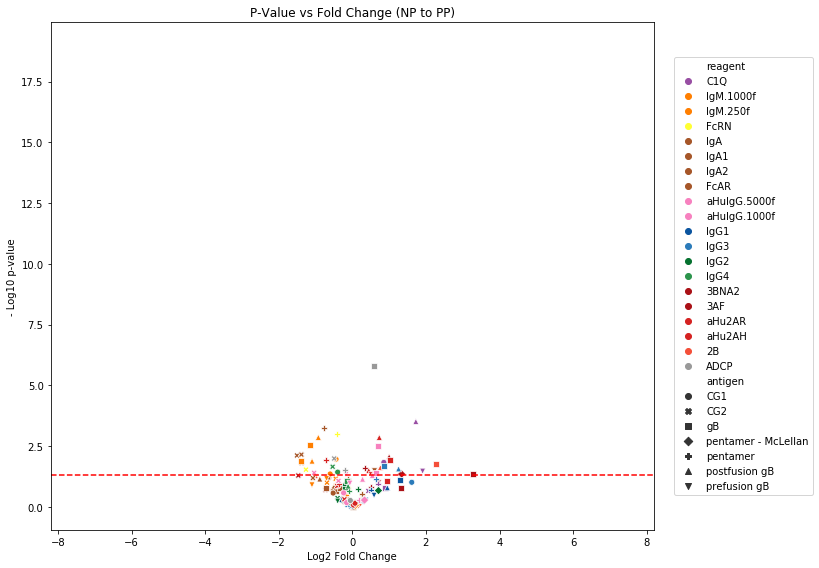

In [246]:
volcanoplot(df, column="Cohort", groups=['NP', 'PP'], filename="volplot_np_pp.png")

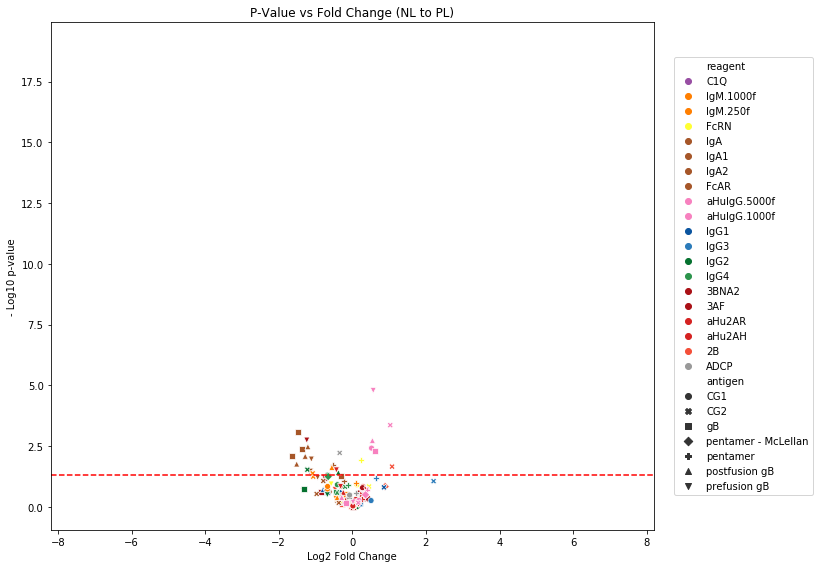

In [247]:
volcanoplot(df, column="Cohort", groups=['NL', 'PL'], filename="volplot_nl_pl.png")

In [169]:
handles,labels = ax.get_legend_handles_labels()

In [173]:
labels

['reagent',
 '2B',
 '3AF',
 '3BNA2',
 'C1Q',
 'FcAR',
 'FcRN',
 'IgA',
 'IgA1',
 'IgA2',
 'IgG1',
 'IgG2',
 'IgG3',
 'IgG4',
 'IgM.1000f',
 'IgM.250f',
 'aHu2AH',
 'aHu2AR',
 'aHuIgG.1000f',
 'aHuIgG.5000f',
 'ADCP',
 'antigen',
 'CG1',
 'CG2',
 'gB',
 'pentamer',
 'pentamer - McLellan',
 'postfusion gB',
 'prefusion gB']

In [44]:
# get statistical significance
# create reagent color map
# create antigen color map

# create primary/latent volcano plot
# create pregnant/non-pregnant volcano plot
# create pp/pl volcano plot
# create np/nl volcano plot
# create pl/nl volcano plot
# create pp/np volcano plot